# Stellar color (B-I)

In [1]:
import pynbody
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pynbody.plot.stars import convert_to_mag_arcsec2
from pynbody.derived import lum_den_template

snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"

s = pynbody.load(snap)

pynbody.analysis.halo.center(s.s, vel=False);

mags = pynbody.analysis.luminosity.calc_mags(s.s)
mags.shape, mags.units

((140168,), NoUnit())

In [2]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from pynbody.derived import lum_den_template
from scipy.ndimage.filters import gaussian_filter

def kpc2pix(qty_kpc, width, resolution):
    kpc_per_pixel = width/resolution
    return int(np.floor(qty_kpc/kpc_per_pixel))

def pix2kpc(qty_pix, width, resolution):
    kpc_per_pixel = width/resolution
    return qty_pix*kpc_per_pixel

def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09  # == 25-5log10(5)
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

def color_plot(snap, bands=('b','i'), width=10, resolution=500, mag_filter=29, subplot=None,
               center=False, title=None, gaussian_sigma=None, cmap_name='seismic', **kwargs):
    """
    Plot the color as defined by the tuple `bands`

    Parameters
    ----------

    gaussian_sigma: in kpc is the sigma of the gaussian to convolve with the image, to make it more realistic

    mag_filter: all region with magnitude/arcsec^2 higher than mag_filter will be set to NaN
    """
    # create color
    assert len(bands) == 2

    if subplot:
        fig, ax = subplot.figure, subplot
    else:
        fig, ax = plt.gcf(), plt.gca()

    if center:
        pynbody.analysis.halo.center(snap.s, vel=False);
    
    # plot the two in 10^(-0.4) mag per pc**2
    band0_pc2 = pynbody.plot.sph.image(snap.s, qty=bands[0] + '_lum_den', units='pc^-2', noplot=True, width=width, log=False, resolution=resolution, **kwargs)
    band1_pc2 = pynbody.plot.sph.image(snap.s, qty=bands[1] + '_lum_den', units='pc^-2', noplot=True, width=width, log=False, resolution=resolution, **kwargs)

    # convert to mag/arcsec**2
    band0_mag_arcsec2 = my_convert_to_mag_arcsec2(band0_pc2)
    band1_mag_arcsec2 = my_convert_to_mag_arcsec2(band1_pc2)

    # Filter below a certain magnitude
    if mag_filter is not None:
        band0_mag_arcsec2[band0_mag_arcsec2 > mag_filter] = np.nan
        band1_mag_arcsec2[band1_mag_arcsec2 > mag_filter] = np.nan

    # create color
    color_mag_arcsec2 = band0_mag_arcsec2 - band1_mag_arcsec2
    color_name = '{}-{}'.format(*bands)

    if gaussian_sigma is not None:
        sigma_pix = kpc2pix(gaussian_sigma, width, resolution)
        print("Smoothing with gaussian kernel with sigma = {} pixel".format(sigma_pix))
        color_mag_arcsec2 = gaussian_filter(color_mag_arcsec2, sigma_pix)
        
#         gaussian_2D_kernel = Gaussian2DKernel(sigma_pix)
#         color_mag_arcsec2 = convolve(color_mag_arcsec2, gaussian_2D_kernel)

    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad('black')
    extent = (-width/2, width/2, -width/2, width/2)
    img = ax.imshow(color_mag_arcsec2, cmap=cmap, interpolation='none', extent=extent, origin='lower')
    cbar = ax.figure.colorbar(img);
    ax.set_xlabel('x/kpc')
    ax.set_ylabel('y/kpc')
    cbar.set_label('{} [mag/arcsec$^2$]'.format(color_name.upper()));
    # cont = ax.contour(img, cmap='flag', extent=(-width/2, width/2, -width/2, width/2))
    if title is not None:
        ax.set_title(title)
    plt.draw()
    return color_mag_arcsec2

In [3]:
s.properties['boxsize'] = pynbody.units.Unit("1 Gpc")

Smoothing with gaussian kernel with sigma = 5 pixel


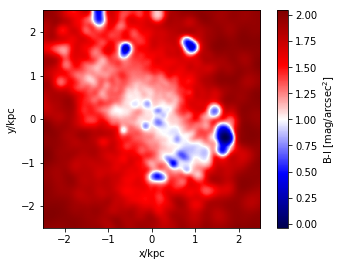

In [4]:
color_plot(s, width=5, bands=('b', 'i'), mag_filter=29, gaussian_sigma=0.05);

# Test metals and [Fe/H]

in hyplot a table called `vazdekis_kroupa_universal.dat` is used, while in pynbody the table of stellar populations of the Padova group Marigo et al (2008), Girardi et al (2010). hyplot usese [Fe/H] to interpolate while pynbody the overal metallicity of the stars. Let's plot the difference.

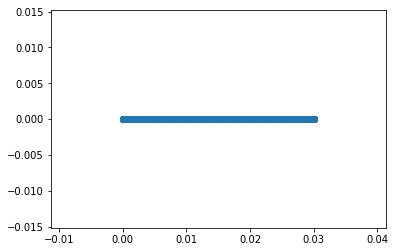

In [5]:
plt.scatter(s.s['metals'], s.s['fest']);

In [6]:
s.s['metals'].min(), s.s['metals'].max()

(SimArray(1.e-04, dtype=float32), SimArray(0.03, dtype=float32))

In [7]:
s.s['fest'].min(), s.s['fest'].max()

(SimArray(0., dtype=float32), SimArray(3.3247092e-09, dtype=float32))

# Test step by step

In [8]:
width = 6
resolution = 500

luminosity density is in unit: 10^(-0.4) mag per unit volume, and it is defined as:

```
val = (10 ** (-0.4 * s[band + "_mag"])) * s['rho'] / s['mass']
val.units = s['rho'].units/s['mass'].units
return val
```

To use `lum_den_template` it is needed to end the magnitude with the string `_mag`.

In [9]:
# s.s['b-i_mag'] = s.s['b_mag'] - s.s['i_mag']

In [10]:
# s.s['b-i_mag']

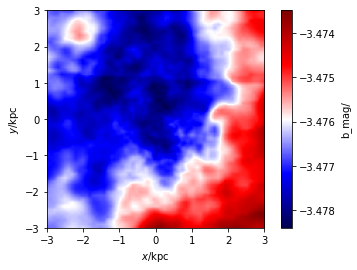

In [11]:
b = pynbody.plot.sph.image(s.s, qty='b_mag', av_z=True, width=width, log=False, resolution=resolution, cmap='seismic')

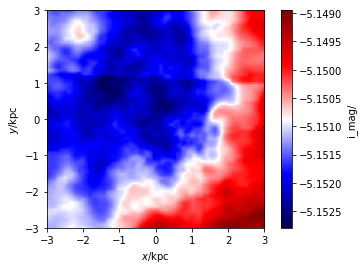

In [12]:
i = pynbody.plot.sph.image(s.s, qty='i_mag', av_z=True, width=width, log=False, resolution=resolution, cmap='seismic')

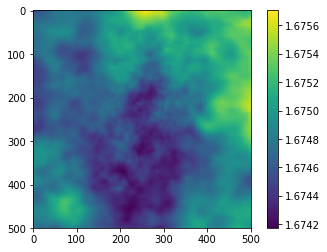

In [13]:
plt.imshow(b-i)
plt.colorbar()

In [14]:
# s.s['b-i_lum_den'] = lum_den_template('b-i', s.s)
# s.s['b-i_lum_den']

In [15]:
# bmi_pc2 = pynbody.plot.sph.image(s.s, qty='b-i_lum_den', units='pc^-2', width=width, log=False, resolution=resolution)

In [16]:
bmi_pc2

NameError: name 'bmi_pc2' is not defined

In [17]:
def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

In [18]:
pynbody.units.pc/pynbody.units.arcsec

Unit("pc arcsec**-1")

In [19]:
# s.s['bmi_mag_arcsec2'] = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2 = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2

NameError: name 'bmi_pc2' is not defined

In [20]:
bmi_mag_arcsec2[bmi_mag_arcsec2 > 29] = np.nan
fig, ax = plt.subplots(1)
cmap = matplotlib.cm.seismic
cmap.set_bad('black')
img = ax.imshow(bmi_mag_arcsec2, cmap=cmap, extent=(-width/2, width/2, -width/2, width/2))
cbar = fig.colorbar(img);

cbar.set_label('B-I [mag/arcsec$^2$]');

NameError: name 'bmi_mag_arcsec2' is not defined

# Try with a real simulation

In [21]:
import simulation

In [22]:
SIMPATH = '/media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out'

In [23]:
sim = simulation.Simulation(SIMPATH)

loading simulation: /media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Loading cosmological parameters
Found trace file


In [29]:
import ipywidgets

snap_slider = ipywidgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0, continuous_update=False, description='Snap:')
# fig, ax = plt.subplots()

def k(i):
    snap = sim[i]
    print(len(snap.s))
    color_plot(snap, width=20, title='{:.2f}'.format(snap.header.time), center=True, mag_filter=32)

w = ipywidgets.interactive(k, i=snap_slider)
w

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=562), Output()), _d…